### **Q-Learning-Based Resource Allocation for Indoor Optical Wireless Systems**

This project implements a reinforcement learning (Q-learning) framework for resource allocation in a steerable, laser-based indoor optical wireless communication system, based on the methodology described in the paper:

> **"Reinforcement Learning for Resource Allocation in Steerable Laser-Based Optical Wireless Systems"**

We simulate a multi-user indoor environment with the following components:

* **4 VCSEL-based arrays** installed on the ceiling.
* **4 photodetector-equipped users**, located either uniformly or clustered.
* **Q-learning** is used to learn the optimal mapping of users to arrays to maximize total SINR under interference and eye-safety constraints.

### **Physical Layer Modeling**

* **Wavelength**: 850 nm
* **Beam Divergence (FWHM)**: 4°
* **Eye-Safe Transmit Power**: Computed from MPE-based models.
* **Gaussian Beam Profile**: Spot size is modeled using far-field divergence.
* **Receiver**: Avalanche photodiode (APD) with:

  * Area: 55 mm × 55 mm
  * Gain: 30
  * Responsivity: 0.54 A/W
  * Includes thermal, shot, and RIN noise.


### **Q-Learning Details**

* **Actions**: Permutations of user-to-array assignments (4! = 24 actions).
* **Reward**: Total SINR (in dB) summed over all users.
* **States**: Stateless Q-learning (Q-table indexed by action only).
* **Exploration**: ε-greedy strategy with exponential decay.

### **Simulated Scenarios**

1. **Scenario 1**: Uniform user distribution across room.
2. **Scenario 2**: Clustered users under one array (crowding).
3. *(Optional Next)*: Mobile user trajectory with dynamic assignment.


### **Visualization and Analysis**

* **SINR per User**: Compared against a QoS threshold (15.6 dB).
* **Beam Assignments**: Top-view line plots showing array-user links.
* **Training Curve**: Q-learning convergence plot (SINR vs. episode).
* **(Optional)**: SINR heatmap under beam footprint for physical insight.



In [135]:
import numpy as np

# Room dimensions
room_dims = (4, 4, 3)

# Transmitter (array) locations on ceiling
arrays = np.array([
    [1, 1, 3],
    [1, 3, 3],
    [3, 1, 3],
    [3, 3, 3]
])

# Scenario 1: Uniform user placement on plane z=1m
users = np.array([
    [1, 1, 1],
    [1, 3, 1],
    [3, 1, 1],
    [3, 3, 1]
])

# Simulation constants
lambda_nm = 850e-9  # Wavelength in meters
FWHM_deg = 4  # Divergence angle
h = 2  # Ceiling to user plane (3 m to 1 m)
Pt = 1.8/1000
# Receiver (APD) parameters
R_APD = 0.54  # A/W
G_APD = 30
kA = 0.7
FA = kA * G_APD + (1 - kA) * (2 - 1 / G_APD)
Aeff = (55e-3)**2  # From 55 mm × 55 mm
BL = 5e9  # Receiver bandwidth [Hz]
RF = 1e3  # Feedback resistance [Ohm]
T = 298  # Room temperature [K]
q = 1.602e-19
kB = 1.38e-23
k_conv = 3  # Arbitrary conversion factor from your code
RIN_dB = -155
RIN = 10**(RIN_dB / 10)
Pn = 6e-10  # Ambient optical power in W (adjustable)


# Compute distance-based LoS gain (simplified Lambertian model not yet included)
def compute_received_power(tx_pos, rx_pos, Pt, FWHM_deg=4):
    d_vec = rx_pos - tx_pos
    r = np.linalg.norm(d_vec[:2])  # radial offset in x-y
    h = abs(d_vec[2])  # vertical distance

    # Beam waist and spot radius at receiver
    theta_FWHM = np.deg2rad(FWHM_deg)
    theta_beam = theta_FWHM / np.sqrt(2 * np.log(2))
    w0 = lambda_nm / (np.pi * theta_beam)
    wh = w0 * np.sqrt(1 + ((lambda_nm * h) / (np.pi * w0**2))**2)

    # Received power at distance r
    Pr = ((2 * Pt * Aeff * G_APD) / (np.pi * wh**2)) * np.exp(-2 * (r**2) / (wh**2)) * (h / np.sqrt(r**2 + h**2))
    
    return Pr, wh, r


# Initial SINR computation
def compute_sinr_matrix(users, arrays, Pt):
    K = len(users)
    L = len(arrays)
    sinr_matrix = np.zeros((K, L))

    for k in range(K):
        for l in range(L):
            Pr_signal, _, _ = compute_received_power(arrays[l], users[k], Pt)

            # Noise PSDs
            S_thermal = 4 * kB * T / RF
            S_shot = 2 * q * (G_APD**2) * FA * R_APD * (Pr_signal + Pn)
            S_rin = RIN * ((R_APD * Pr_signal)**2)

            noise_power = (BL / 2) * (S_thermal + S_shot + S_rin)
            sinr = (R_APD**2 * Pr_signal**2) / noise_power
            sinr_matrix[k, l] = 10 * np.log10(sinr + 1e-12)  # dB

    return sinr_matrix

sinr_matrix = compute_sinr_matrix(users, arrays,Pt)
print("Initial SINR matrix (dB):\n", np.round(sinr_matrix, 2))

Initial SINR matrix (dB):
 [[  24.09 -120.   -120.   -120.  ]
 [-120.     24.09 -120.   -120.  ]
 [-120.   -120.     24.09 -120.  ]
 [-120.   -120.   -120.     24.09]]


In [128]:
import itertools
import random

# Problem setup
K = len(users)       # Number of users
L = len(arrays)      # Number of arrays
min_sinr_db = 15.6   # QoS threshold for each user

# All valid actions: each user assigned to a unique array (no conflicts)
valid_actions = list(itertools.permutations(range(L), K))
print(f"Total valid actions: {len(valid_actions)}")

# QoS function: returns tuple like (1, 0, 1, 1)
def get_qos_state(sinr_vector):
    return tuple(int(s >= min_sinr_db) for s in sinr_vector)

# Initialize stateless Q-table: key = (None, action)
Q_table = {}  # Q[(None, action)] = Q-value

# Q-learning hyperparameters
alpha = 0.5           # Learning rate
reward_log = []
gamma = 0.9           # Discount factor
epsilon = 1.0         # Initial exploration rate
epsilon_decay = 0.99  # Decay per episode
num_episodes = 2000   # Training steps


Total valid actions: 24


In [129]:
def take_action(action):
    sinr_per_user = []
    used_arrays = list(action)
    
    for k in range(K):
        user_pos = users[k]
        assigned_array = arrays[used_arrays[k]]

        # Compute signal component
        Pr_signal, _, _ = compute_received_power(assigned_array, user_pos, Pt)

        # Compute interference from other arrays
        interference_power = 0
        interference_power = 0
        for j in range(L):
            if j != used_arrays[k]:
                Pr_interf, _, _ = compute_received_power(arrays[j], user_pos, Pt)
                interference_power += Pr_interf

        # Noise power (thermal + shot + RIN)
        S_thermal = 4 * kB * T / RF
        S_shot = 2 * q * (G_APD**2) * FA * R_APD * (Pr_signal + Pn)
        S_rin = RIN * ((R_APD * Pr_signal)**2)
        noise_power = (BL / 2) * (S_thermal + S_shot + S_rin)

        # SINR computation
        sinr = (R_APD**2 * Pr_signal**2) / (noise_power + R_APD**2 * interference_power + 1e-15)
        sinr_db = 10 * np.log10(sinr + 1e-12)
        sinr_per_user.append(sinr_db)
        # sinr_per_user = [max(s, -100) for s in sinr_per_user]


    qos = get_qos_state(sinr_per_user)
    reward = sum(sinr_per_user)
    return qos, reward, sinr_per_user



In [130]:
for episode in range(num_episodes):
    # Step 1: Choose an action (ε-greedy)
    if random.random() < epsilon:
        action = random.choice(valid_actions)
    else:
        # Exploit best known action for any state (stateless, global max)
        q_values = [Q_table.get((None, a), 0) for a in valid_actions]
        max_index = int(np.argmax(q_values))
        action = valid_actions[max_index]

    # Step 2: Take action, get SINRs and reward
    state, reward, sinr_vector = take_action(action)

    # === Track reward ===
    reward_log.append(reward)

    # Step 3: Update Q-value (stateless)
    old_q = Q_table.get((None, action), 0)
    future_qs = [Q_table.get((None, a), 0) for a in valid_actions]
    max_future_q = max(future_qs)
    new_q = (1 - alpha) * old_q + alpha * (reward + gamma * max_future_q)
    Q_table[(None, action)] = new_q

    # Step 4: Decay epsilon
    epsilon *= epsilon_decay
    epsilon = max(epsilon, 0.01)

    # Debug output
    if episode % 500 == 0 or episode == num_episodes - 1:
        print(f"Episode {episode}: Total Reward = {round(reward, 2)} dB, ε = {round(epsilon, 3)}")


Episode 0: Total Reward = -335.91 dB, ε = 0.99
Episode 500: Total Reward = 96.36 dB, ε = 0.01
Episode 1000: Total Reward = 96.36 dB, ε = 0.01
Episode 1500: Total Reward = 96.36 dB, ε = 0.01
Episode 1999: Total Reward = 96.36 dB, ε = 0.01


In [131]:
# Evaluate the best learned policy after training
best_action = max(valid_actions, key=lambda a: Q_table.get((None, a), -np.inf))
_, best_total_reward, best_sinrs = take_action(best_action)

print("\nBest Action (User → Array):", best_action)
for idx, sinr in enumerate(best_sinrs):
    print(f"   • User {idx + 1}: SINR = {sinr:.2f} dB")
print("Total SINR:", round(best_total_reward, 2), "dB")


Best Action (User → Array): (0, 1, 2, 3)
   • User 1: SINR = 24.09 dB
   • User 2: SINR = 24.09 dB
   • User 3: SINR = 24.09 dB
   • User 4: SINR = 24.09 dB
Total SINR: 96.36 dB


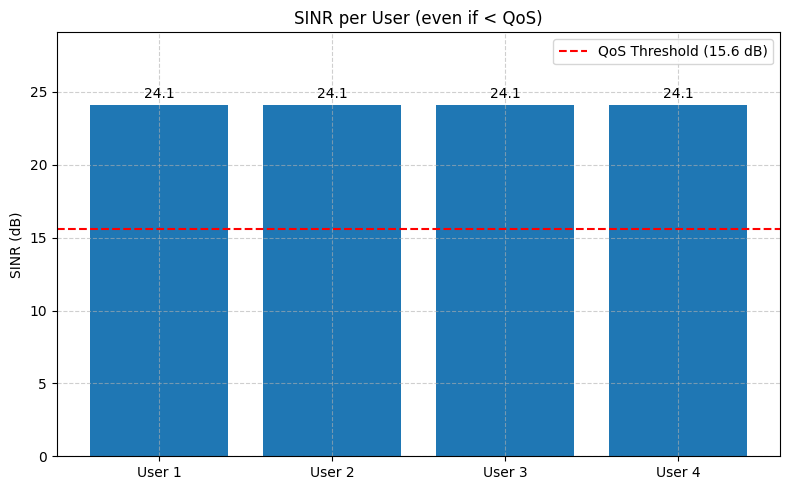

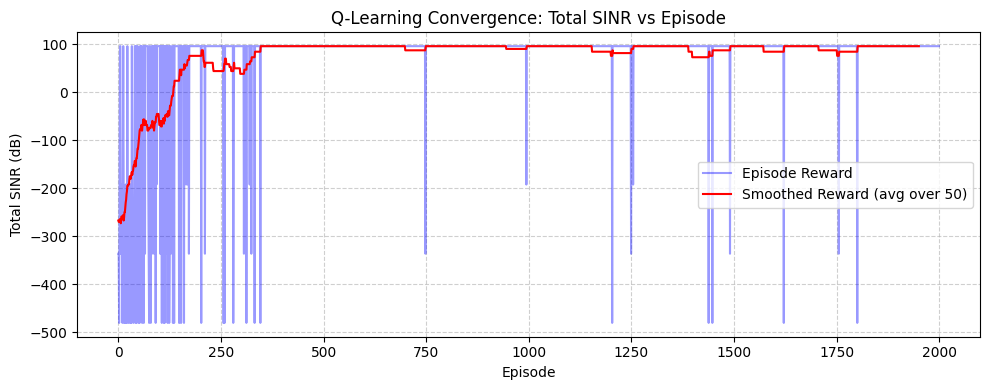

In [134]:
import matplotlib.pyplot as plt

def moving_average(data, window_size=50):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_sinr_per_user(sinr_vector, title="SINR per User (Q-Learning Allocation)"):
    users = [f"User {i+1}" for i in range(len(sinr_vector))]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(users, sinr_vector)
    plt.axhline(y=min_sinr_db, color='r', linestyle='--', label="QoS Threshold (15.6 dB)")
    plt.ylabel("SINR (dB)")
    plt.ylim(0, max(20, max(sinr_vector) + 5))
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    for bar, val in zip(bars, sinr_vector):
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.5, f"{val:.1f}", ha='center')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.plot(reward_log, label="Episode Reward", color="blue", alpha=0.4)
    plt.plot(moving_average(reward_log), label="Smoothed Reward (avg over 50)", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Total SINR (dB)")
    plt.title("Q-Learning Convergence: Total SINR vs Episode")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_sinr_per_user(best_sinrs, title="SINR per User (even if < QoS)")



### Scenario 2: Crowded Users Under One Array

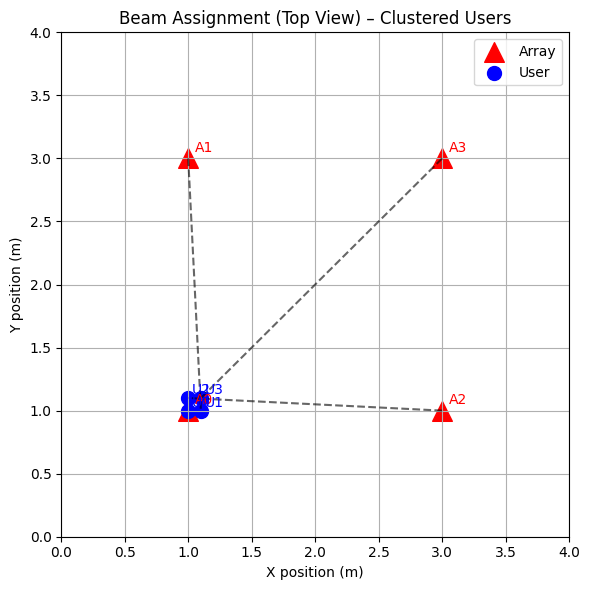

In [116]:
# Scenario 2: Clustered users below one AP (array 0)
users = np.array([
    [1.0, 1.0, 1.0],  # directly beneath array 0
    [1.1, 1.0, 1.0],
    [1.0, 1.1, 1.0],
    [1.1, 1.1, 1.0]
])
def plot_beam_allocation(users, arrays, best_action):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot arrays (transmitters)
    for i, array in enumerate(arrays):
        ax.scatter(array[0], array[1], c='red', marker='^', s=200, label='Array' if i==0 else "")
        ax.text(array[0]+0.05, array[1]+0.05, f"A{i}", color='red', fontsize=10)
    
    # Plot users (receivers) and draw lines to assigned arrays
    for i, user in enumerate(users):
        ax.scatter(user[0], user[1], c='blue', marker='o', s=100, label='User' if i==0 else "")
        assigned_array = arrays[best_action[i]]
        ax.plot([assigned_array[0], user[0]], [assigned_array[1], user[1]], 'k--', alpha=0.6)
        ax.text(user[0]+0.03, user[1]+0.03, f"U{i}", color='blue', fontsize=10)

    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    ax.set_title("Beam Assignment (Top View) – Clustered Users")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_beam_allocation(users, arrays, best_action)


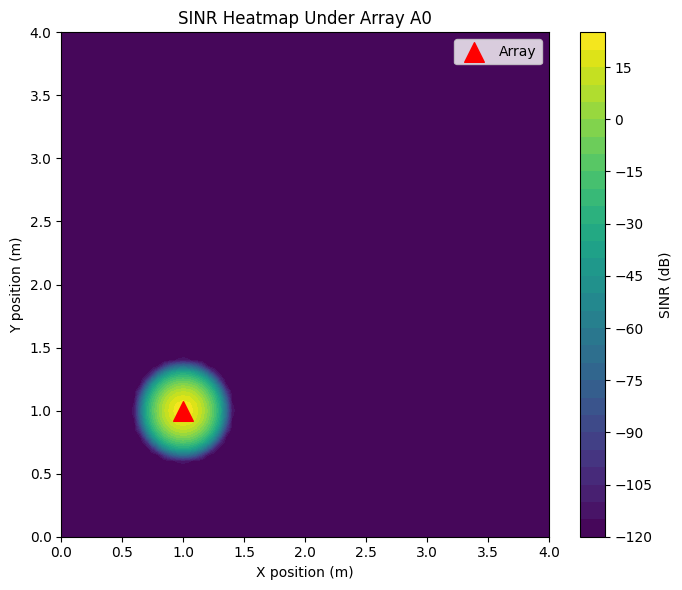

In [118]:
def plot_sinr_heatmap_for_array(array_id=0, grid_res=0.05):
    x_vals = np.arange(0, 4+grid_res, grid_res)
    y_vals = np.arange(0, 4+grid_res, grid_res)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            user_pos = np.array([X[i, j], Y[i, j], 1.0])  # z=1m plane
            Pr, _, _ = compute_received_power(arrays[array_id], user_pos, Pt)

            S_thermal = 4 * kB * T / RF
            S_shot = 2 * q * (G_APD**2) * FA * R_APD * (Pr + Pn)
            S_rin = RIN * ((R_APD * Pr)**2)
            noise_power = (BL / 2) * (S_thermal + S_shot + S_rin)
            sinr = (R_APD**2 * Pr**2) / (noise_power + 1e-15)
            Z[i, j] = 10 * np.log10(sinr + 1e-12)

    plt.figure(figsize=(7, 6))
    cp = plt.contourf(X, Y, Z, levels=30, cmap="viridis")
    plt.colorbar(cp, label="SINR (dB)")
    plt.title(f"SINR Heatmap Under Array A{array_id}")
    plt.xlabel("X position (m)")
    plt.ylabel("Y position (m)")
    plt.scatter(arrays[array_id][0], arrays[array_id][1], c='red', marker='^', s=200, label='Array')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_sinr_heatmap_for_array(array_id=0)  # or array_id=1,2,3


In [136]:
# Mobile user path: line from (0.5, 0.5, 1.0) → (3.5, 3.5, 1.0)
num_steps = 100
x_path = np.linspace(0.5, 3.5, num_steps)
y_path = np.linspace(0.5, 3.5, num_steps)
z = 1.0  # fixed height

user_path = np.array([[x, y, z] for x, y in zip(x_path, y_path)])


In [137]:
# Evaluate Best Array at Each Step (Greedy)
sinr_log = []
array_log = []

for user_pos in user_path:
    best_sinr = -np.inf
    best_array = -1
    
    for i, array_pos in enumerate(arrays):
        Pr_signal, _, _ = compute_received_power(array_pos, user_pos, Pt)

        S_thermal = 4 * kB * T / RF
        S_shot = 2 * q * (G_APD**2) * FA * R_APD * (Pr_signal + Pn)
        S_rin = RIN * ((R_APD * Pr_signal)**2)
        noise_power = (BL / 2) * (S_thermal + S_shot + S_rin)

        sinr = (R_APD**2 * Pr_signal**2) / (noise_power + 1e-15)
        sinr_db = 10 * np.log10(sinr + 1e-12)

        if sinr_db > best_sinr:
            best_sinr = sinr_db
            best_array = i

    sinr_log.append(best_sinr)
    array_log.append(best_array)


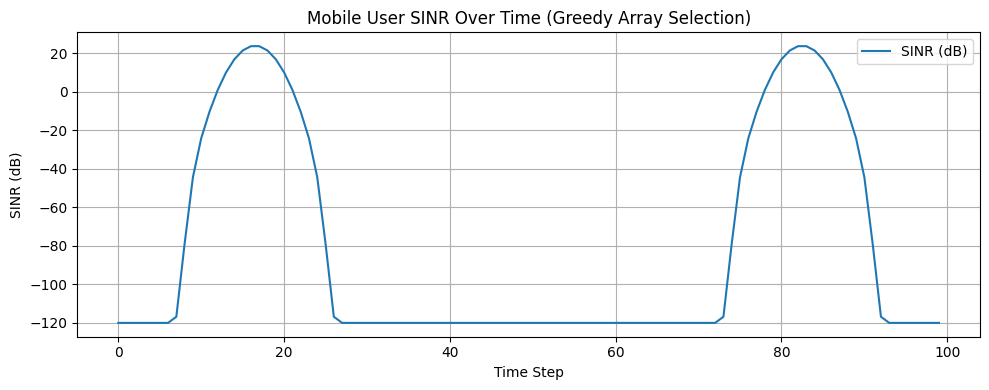

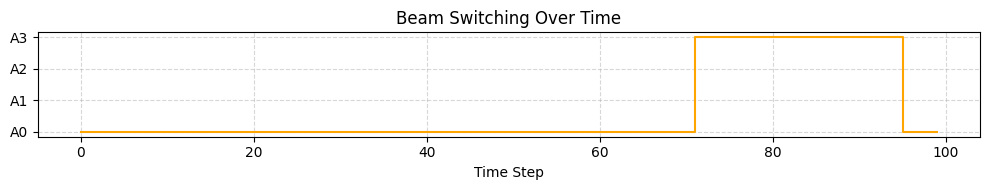

In [138]:
# Step 3: Plot SINR and Switching Events
plt.figure(figsize=(10, 4))
plt.plot(sinr_log, label="SINR (dB)")
plt.xlabel("Time Step")
plt.ylabel("SINR (dB)")
plt.title("Mobile User SINR Over Time (Greedy Array Selection)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: plot array switching events
plt.figure(figsize=(10, 2))
plt.plot(array_log, drawstyle='steps-post', label='Selected Array', color='orange')
plt.yticks(range(len(arrays)), [f"A{i}" for i in range(len(arrays))])
plt.xlabel("Time Step")
plt.title("Beam Switching Over Time")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [139]:
# upgrade Scenario 3 to full online Q-learning, where the agent learns to select the best beam dynamically as the mobile user walks across the room.

# At each time step, the agent chooses an array (action) based on current user position (state), receives a reward (SINR), and learns to optimize future selections.

# Discretize the room into grid cells for states
grid_size = 0.5  # meters
grid_x = int(room_dims[0] / grid_size)
grid_y = int(room_dims[1] / grid_size)

def get_state(user_pos):
    x_idx = int(user_pos[0] / grid_size)
    y_idx = int(user_pos[1] / grid_size)
    return (x_idx, y_idx)


In [140]:
actions = list(range(len(arrays)))  # 4 arrays → 4 actions
Q = {}  # Key: (state, action), Value: Q-value
alpha = 0.5       # learning rate
gamma = 0.9       # discount factor
epsilon = 1.0     # exploration
epsilon_decay = 0.995
min_epsilon = 0.01
sinr_log = []
array_log = []

for t, user_pos in enumerate(user_path):
    state = get_state(user_pos)

    # ε-greedy action selection
    if np.random.rand() < epsilon:
        action = random.choice(actions)
    else:
        q_vals = [Q.get((state, a), 0) for a in actions]
        action = int(np.argmax(q_vals))

    # Take action → compute SINR as reward
    Pr_signal, _, _ = compute_received_power(arrays[action], user_pos, Pt)
    S_thermal = 4 * kB * T / RF
    S_shot = 2 * q * (G_APD**2) * FA * R_APD * (Pr_signal + Pn)
    S_rin = RIN * ((R_APD * Pr_signal)**2)
    noise_power = (BL / 2) * (S_thermal + S_shot + S_rin)
    sinr = (R_APD**2 * Pr_signal**2) / (noise_power + 1e-15)
    sinr_db = 10 * np.log10(sinr + 1e-12)

    # Reward is SINR (or could add switching penalty)
    reward = sinr_db

    # Observe next state
    next_state = get_state(user_path[t]) if t < len(user_path)-1 else state

    # Q-value update
    future_qs = [Q.get((next_state, a), 0) for a in actions]
    max_future_q = max(future_qs)
    old_q = Q.get((state, action), 0)
    new_q = (1 - alpha) * old_q + alpha * (reward + gamma * max_future_q)
    Q[(state, action)] = new_q

    # Log results
    sinr_log.append(sinr_db)
    array_log.append(action)

    # Decay ε
    epsilon = max(min_epsilon, epsilon * epsilon_decay)


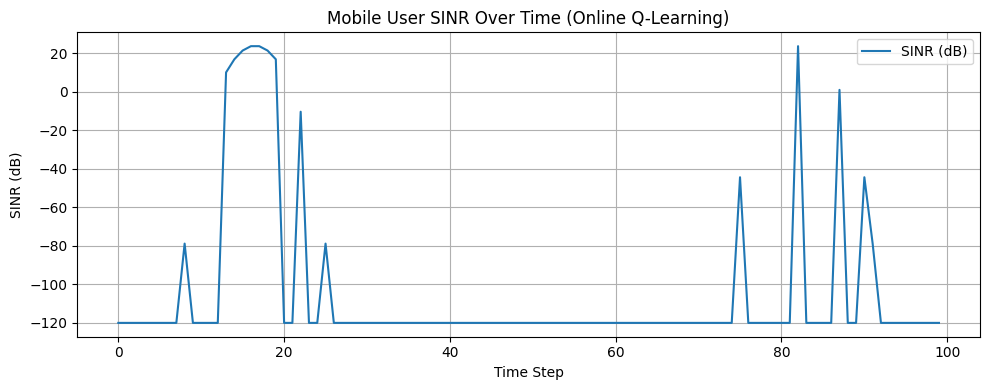

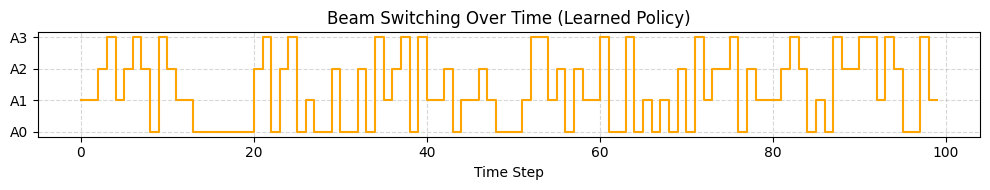

In [141]:
plt.figure(figsize=(10, 4))
plt.plot(sinr_log, label="SINR (dB)")
plt.xlabel("Time Step")
plt.ylabel("SINR (dB)")
plt.title("Mobile User SINR Over Time (Online Q-Learning)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(array_log, drawstyle='steps-post', label='Selected Array', color='orange')
plt.yticks(range(len(arrays)), [f"A{i}" for i in range(len(arrays))])
plt.xlabel("Time Step")
plt.title("Beam Switching Over Time (Learned Policy)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

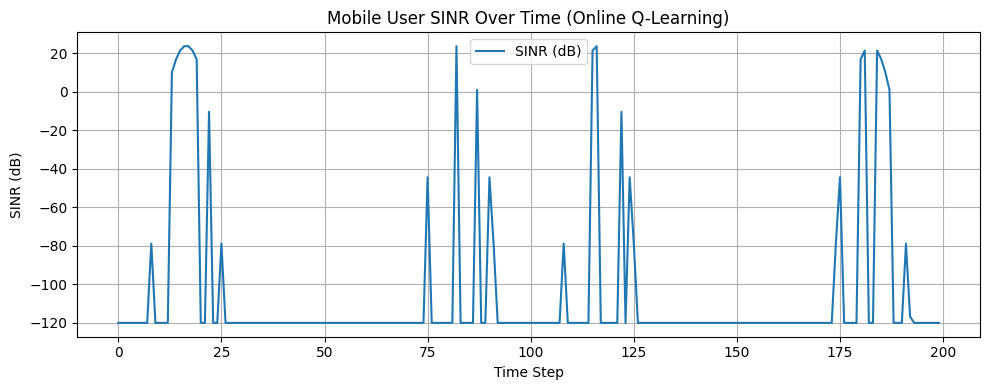

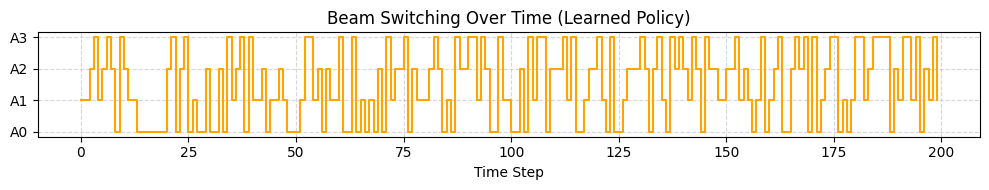

In [142]:
# Penalize the agent if it switches arrays too frequently (i.e., selects a different array from the last time step).
handover_penalty = 5  # dB penalty per switch (tune this)
prev_action = None
reward = sinr_db
reward = sinr_db
if prev_action is not None and action != prev_action:
    reward -= handover_penalty
prev_action = action
for t, user_pos in enumerate(user_path):
    state = get_state(user_pos)

    # ε-greedy action selection
    if np.random.rand() < epsilon:
        action = random.choice(actions)
    else:
        q_vals = [Q.get((state, a), 0) for a in actions]
        action = int(np.argmax(q_vals))

    # Take action → compute SINR as reward
    Pr_signal, _, _ = compute_received_power(arrays[action], user_pos, Pt)
    S_thermal = 4 * kB * T / RF
    S_shot = 2 * q * (G_APD**2) * FA * R_APD * (Pr_signal + Pn)
    S_rin = RIN * ((R_APD * Pr_signal)**2)
    noise_power = (BL / 2) * (S_thermal + S_shot + S_rin)
    sinr = (R_APD**2 * Pr_signal**2) / (noise_power + 1e-15)
    sinr_db = 10 * np.log10(sinr + 1e-12)

    # Reward is SINR (or could add switching penalty)
    reward = sinr_db

    # Observe next state
    next_state = get_state(user_path[t]) if t < len(user_path)-1 else state

    # Q-value update
    future_qs = [Q.get((next_state, a), 0) for a in actions]
    max_future_q = max(future_qs)
    old_q = Q.get((state, action), 0)
    new_q = (1 - alpha) * old_q + alpha * (reward + gamma * max_future_q)
    Q[(state, action)] = new_q

    # Log results
    sinr_log.append(sinr_db)
    array_log.append(action)

    # Decay ε
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

plt.figure(figsize=(10, 4))
plt.plot(sinr_log, label="SINR (dB)")
plt.xlabel("Time Step")
plt.ylabel("SINR (dB)")
plt.title("Mobile User SINR Over Time (Online Q-Learning)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(array_log, drawstyle='steps-post', label='Selected Array', color='orange')
plt.yticks(range(len(arrays)), [f"A{i}" for i in range(len(arrays))])
plt.xlabel("Time Step")
plt.title("Beam Switching Over Time (Learned Policy)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()